In [1]:
import cv2
import numpy as np
import torch
import torch.nn.functional as F
from PIL import Image
from torch import nn

from nets.liteNet import FreezyNet
from nets.LiteRASPP import LiteRASPP

from glob import glob
import random

import matplotlib.pyplot as plt
import torch.nn.functional as F
from tqdm import tqdm
import os
import pandas as pd


In [56]:
with open('skip.txt') as f:
    skip=f.read().split('\n')
validation=0.2
files=sorted(glob('../无人机冻害/VOCdevkit/VOC2007/SegmentationClass3/*.png'))
files_s=[]
for f in files:
    if f.split('/')[-1] in skip: 
        continue
    files_s.append(f)
len(files_s)

0

In [2]:
def average_non_zero_pixel(gray_image):
    non_zero_indices = np.nonzero(gray_image)
    non_zero_values = gray_image[non_zero_indices]
    average_value = np.mean(non_zero_values)
    return average_value

def get_green_yello_ratio(new,mask):
    hsv=cv2.cvtColor(new,cv2.COLOR_BGR2HSV)
    lower_green = np.array([25, 45, 0])
    upper_green = np.array([180, 255, 240])
    
    green_mask = cv2.inRange(hsv, lower_green, upper_green)
    new1 = cv2.bitwise_and(new,new,mask=green_mask)
#     plt.figure(dpi=200)
#     plt.imshow(new1[:,:,::-1])
#     plt.show()
    
#     new2=new-new1
#     plt.figure(dpi=200)

#     plt.imshow(new2[:,:,::-1])
#     plt.show()
#     cv2.imwrite('n1.jpg',new1)
#     cv2.imwrite('n2.jpg',new2)
#     cv2.imwrite('n3.jpg',new)
    yellow_mask=255*mask-green_mask
    yellow_hsv=cv2.bitwise_and(hsv,hsv,mask=yellow_mask)
    # plt.imshow(yellow_hsv[:,:,::-1])
    # plt.show()
    green_pixels = cv2.countNonZero(green_mask)
    total_pixels = cv2.countNonZero(mask)
    h,s,v=cv2.split(hsv)
    
    h_value=average_non_zero_pixel(h)
    s_value=average_non_zero_pixel(s)

    
    h,s,v=cv2.split(yellow_hsv)
    h_y=average_non_zero_pixel(h)
    s_y=average_non_zero_pixel(s)
    
    if total_pixels==0:
        return 0
    ratio_green = green_pixels / total_pixels
    return ratio_green,green_pixels,total_pixels-green_pixels,h_value,s_value,h_y,s_y



def post_process(output,image):
    mask=cv2.merge([output,output,output])
    bitimage = cv2.bitwise_and(image,image,mask=output)
    lower_gray = np.array([0, 0, 100], dtype=np.uint8)
    upper_gray = np.array([255, 50, 255], dtype=np.uint8)
    hsv = cv2.cvtColor(bitimage, cv2.COLOR_BGR2HSV)
    gray_pixels = cv2.inRange(hsv, lower_gray, upper_gray)
    bitimage[gray_pixels>0] = (0, 0, 0) 
    output[gray_pixels>0] = 0

In [3]:
table={}
for i in glob('../../phone_label/*/*'):
    fname=i.split('/')[-1].split('.')[0]
    table[fname]=i
    
    
input_shape=(512,512)
model = FreezyNet()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.load_state_dict(torch.load('logs/FreezyNet_/phoneLite.pth', map_location=device))
model = model.eval()

model = nn.DataParallel(model)
model = model.cuda()


In [154]:
    
files=sorted(glob('VOCdevkit/VOC2007/SegmentationClass3/*C*.png'))
random.seed(6666)
random.shuffle(files)
files_s=files[:121]
validation=0.1
val_lines=files_s[:int(validation*len(files_s))]
train_lines=files_s[int(validation*len(files_s)):]
test_lines=files[121:]
len(files)


input_shape=(512,512)
hist = np.zeros((2, 2))


Progress::   0%|          | 0/12 [00:00<?, ?it/s<class 'dict'>]

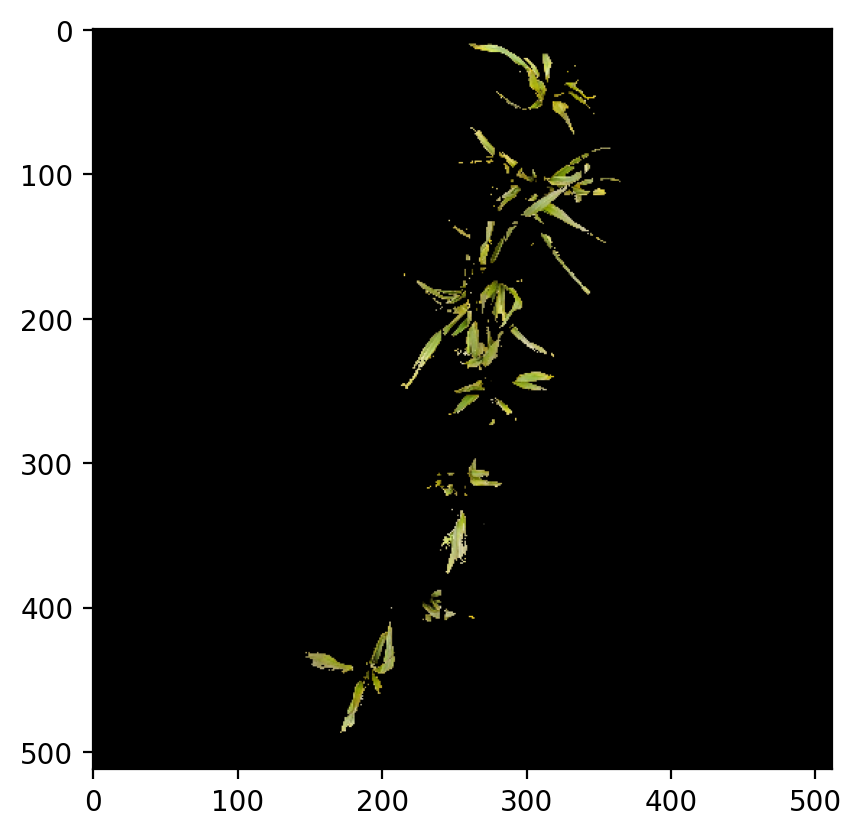

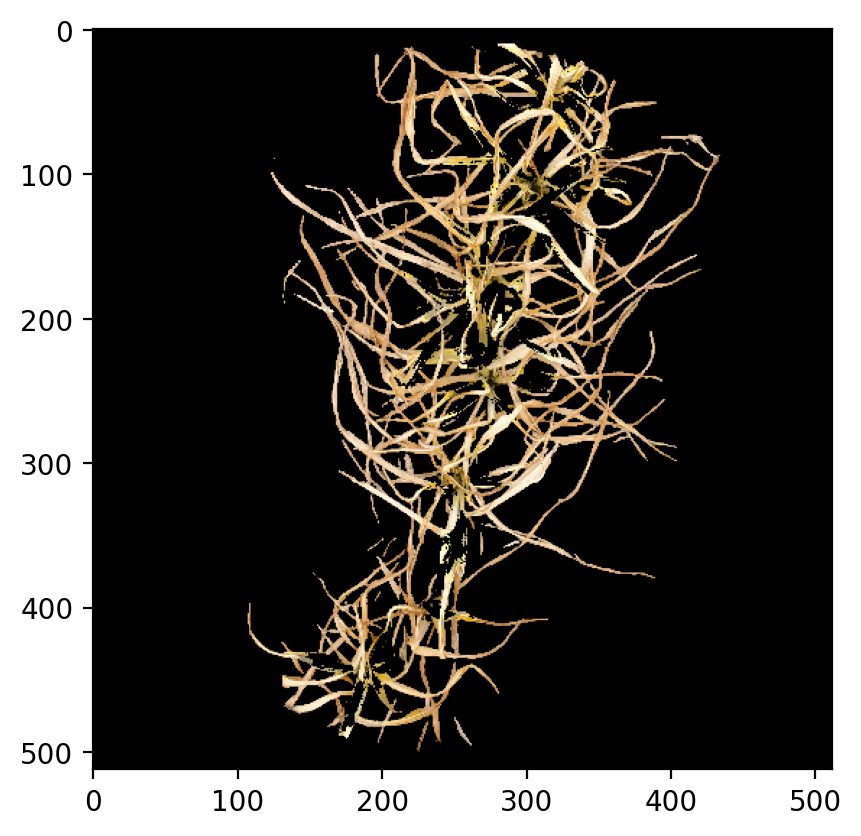

0


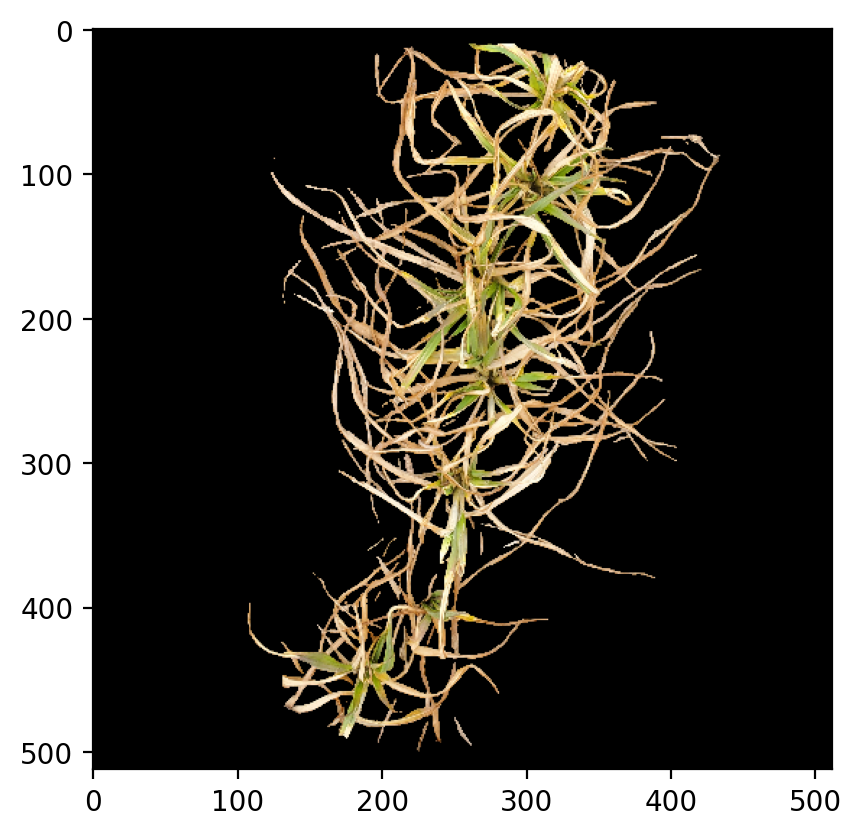

Progress::   0%|          | 0/12 [00:02<?, ?it/s<class 'dict'>]


In [155]:


with tqdm(total=len(val_lines),desc='Progress:',postfix=dict,mininterval=0.3) as pbar:
    for index,file in enumerate(train_lines[102:]):
        label = cv2.imread(file,0)
        image = cv2.imread(table[file.split('/')[-1].split('.')[0]])
        h,w=image.shape[:2]
        if h<w:
            image=cv2.rotate(image,cv2.ROTATE_90_CLOCKWISE)
            label=cv2.rotate(label,cv2.ROTATE_90_CLOCKWISE)
            h,w=w,h
        ratio=512/w
        temp=image.copy()
        ori_image=image.copy()
        gray = cv2.cvtColor(temp, cv2.COLOR_RGB2GRAY)
        temp=cv2.resize(temp,(int(w*ratio),int(h*ratio)))

        hsv_image = cv2.cvtColor(temp, cv2.COLOR_BGR2HSV)

        lower_gray = np.array([0, 0, 100], dtype=np.uint8)
        upper_gray = np.array([255, 50, 255], dtype=np.uint8)

        mask = cv2.inRange(hsv_image, lower_gray, upper_gray)

        temp = cv2.bitwise_and(temp, temp, mask=mask)



        gray = cv2.cvtColor(temp, cv2.COLOR_RGB2GRAY)
        kernel_size = (5, 5)  # 设置滤波核的大小
        gray = cv2.blur(gray, kernel_size)


        ret, thresholded_image = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)


        circles = cv2.HoughCircles(gray, cv2.HOUGH_GRADIENT, 1, 500, param1=40, param2=80, minRadius=200, maxRadius=240)
        x1,x2,y1,y2=(round((circles[0][0][0]-circles[0][0][2])/ratio),
                 round((circles[0][0][0]+circles[0][0][2])/ratio),
                 round((circles[0][0][1]-circles[0][0][2])/ratio),
                 round((circles[0][0][1]+circles[0][0][2])/ratio))

        new=np.zeros((int(h),int(w),3),dtype=np.uint8)
        cv2.circle(new, (round(circles[0][0][0]/ratio), round(circles[0][0][1]/ratio)), round(circles[0][0][2]/ratio), (255, 255, 255), -1)

        image=cv2.bitwise_and(image,new)
        image=image[y1:y2,x1:x2,:]
        label=cv2.bitwise_and(label,new[:,:,0])
        label=label[y1:y2,x1:x2]

        #------------------------------------------#
        #   resize
        #------------------------------------------#        
        image=cv2.resize(image,(input_shape[0],input_shape[0]))
        label=cv2.resize(label,(input_shape[0],input_shape[0]))

        img=torch.Tensor([image/255]).cuda()
        img=img.permute(0,3,1,2)
        #lb=torch.Tensor([label]).cuda()
        with torch.no_grad():
            output=model(img)
        output = output[0].permute(1,2,0).cpu().argmax(axis=-1).numpy().astype(np.uint8)
        new = cv2.bitwise_and(image,image,mask=output)
        r,g,y=get_green_yello_ratio(new,output)  
        
        
        output=output.astype(np.uint8)*255
        pred_mask=cv2.merge([output,output,output])

        pred_mask[:,:,0]=0
        pred_mask[:,:,1]=0
        
        result = cv2.addWeighted(image, 0.5, pred_mask, 0.5, 0)
        print(index)
        plt.figure(dpi=200)
        plt.imshow(new[:,:,::-1])
        plt.show()
        break



In [122]:
cv2.imwrite('n4.jpg',image)


True

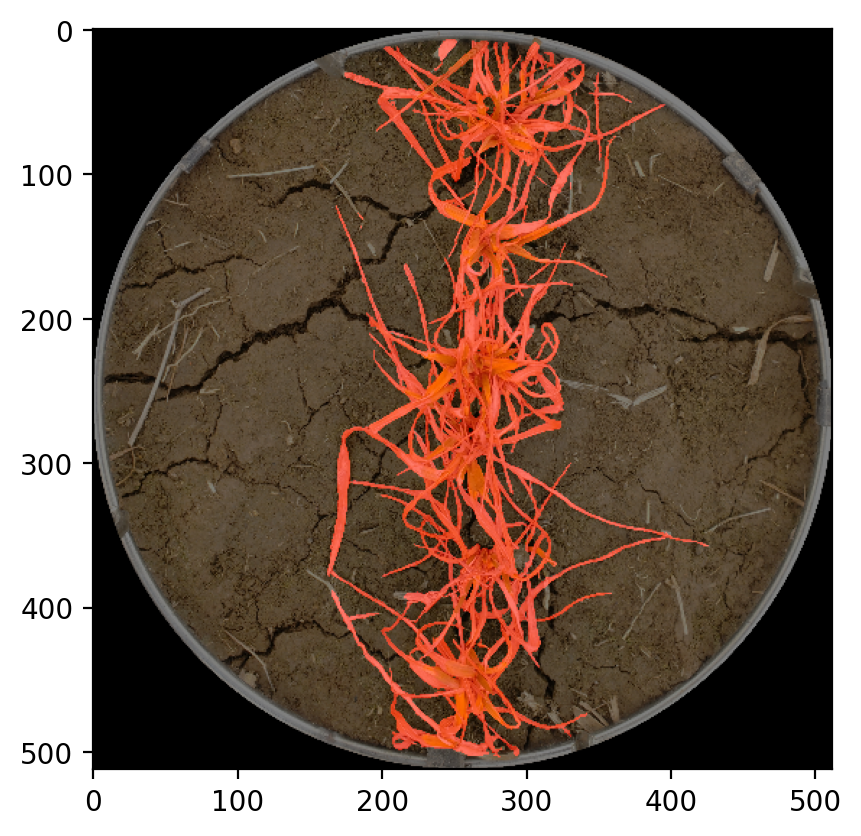

In [80]:
result = cv2.addWeighted(image, 0.5, pred_mask, 0.5, 0)
plt.figure(dpi=200)
plt.imshow(result[:,:,::-1])
plt.show()

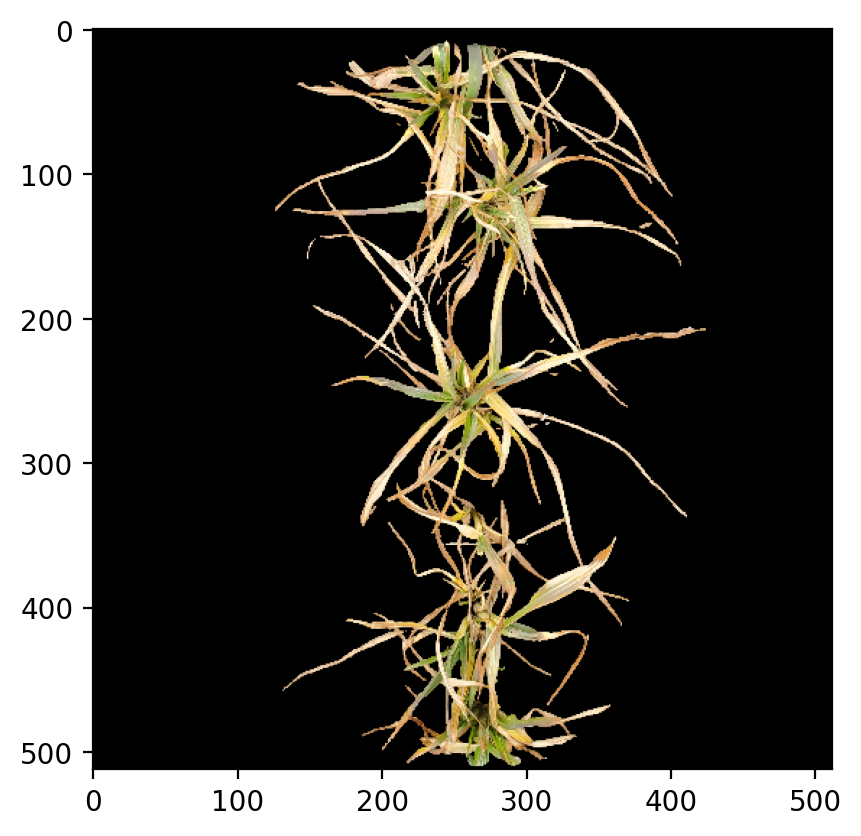

In [108]:
plt.figure(dpi=200)
plt.imshow(new[:,:,::-1])
plt.show()

In [4]:
#files=glob('/public/lab_share/nfs_data/raw_data/wheat/2022/AA221/winterhardness/*C*.jpg')
files=glob('/public/lab_share/nfs_data/raw_data/wheat/2022/CN_USA_BC3/winterheadness/*.jpg')

#files.extend()
len(files)

143

In [6]:
input_shape=(512,512)


content='区号,绿叶比重,黄叶比重,绿叶面积,黄叶面积,总叶面积,H通道,S通道\n'

if not os.path.exists('phone_phenotypes_P_1202.csv'):
    with open('phone_phenotypes_P_0409.csv','w',encoding='utf-8') as f:
        f.write(content)
    load=[]   
else:
    csv=pd.read_csv('phone_phenotypes_P_1202.csv')
    load=csv['区号'].tolist()
files.sort()
with tqdm(total=len(files),desc='Progress:',postfix=dict,mininterval=0.3) as pbar:
    for index,file in enumerate(files):
        #label = cv2.imread(file,0)
        if 'P065' not in file and  'P066' not in file:
            continue
            
        imgname=file.split('/')[-1].split('.')[0]
#         if imgname in load:
#             continue
       
        # if 'C265' not in file:
        #     continue
        image = cv2.imread(file)
        h,w=image.shape[:2]
        
        #plt.imshow(image[:,:,::-1])
        #plt.show()


        if h<w:
            image=cv2.rotate(image,cv2.ROTATE_90_CLOCKWISE)
            #label=cv2.rotate(label,cv2.ROTATE_90_CLOCKWISE)
            h,w=w,h
        ratio=512/w
        temp=image.copy()

        temp=cv2.resize(temp,(int(w*ratio),int(h*ratio)))
        gray = cv2.cvtColor(temp, cv2.COLOR_RGB2GRAY)


        '''hsv_image = cv2.cvtColor(temp, cv2.COLOR_BGR2HSV)
        lower_gray = np.array([0, 0, 120], dtype=np.uint8)
        upper_gray = np.array([240, 250, 250], dtype=np.uint8)
        mask = cv2.inRange(hsv_image, lower_gray, upper_gray)
        temp = cv2.bitwise_and(temp, temp, mask=mask)
        plt.imshow(mask)
        plt.show()'''


        b,g,r=cv2.split(temp)
        crt1=abs(gray.astype(np.int32)-r.astype(np.int32))<50
        crt2=abs(gray.astype(np.int32)-g.astype(np.int32))<50
        crt3=abs(gray.astype(np.int32)-b.astype(np.int32))<50


        rcrt1=r.astype(np.int32)-b.astype(np.int32)>15
        rcrt2=g.astype(np.int32)-b.astype(np.int32)>15

        rcrt3=abs(r.astype(np.int32)-g.astype(np.int32))>20

        rcrt4=cv2.bitwise_and(rcrt1.astype(np.uint8),rcrt2.astype(np.uint8))
        rcrt=cv2.bitwise_and(rcrt3.astype(np.uint8),rcrt4.astype(np.uint8))




        crt4=gray>100
        crt5=cv2.bitwise_and(crt1.astype(np.uint8),crt2.astype(np.uint8))
        crt6=cv2.bitwise_and(crt3.astype(np.uint8),crt5.astype(np.uint8))

        crt7=cv2.bitwise_and(crt6.astype(np.uint8),1-rcrt2.astype(np.uint8))


        mask=cv2.bitwise_and(crt4.astype(np.uint8),crt7.astype(np.uint8))

        #plt.imshow(mask)
        #plt.show()

        temp = cv2.bitwise_and(temp, temp, mask=mask)




        gray = cv2.cvtColor(temp, cv2.COLOR_RGB2GRAY)
        kernel_size = (5, 5)  # 设置滤波核的大小
        gray = cv2.blur(gray, kernel_size)


        #plt.imshow(gray)
        #plt.show()

        circles = cv2.HoughCircles(gray, cv2.HOUGH_GRADIENT, 2, 500, param1=40, param2=80, minRadius=200, maxRadius=240)
        #print(circles)



        x1,x2,y1,y2=(round((circles[0][0][0]-circles[0][0][2])/ratio),
                 round((circles[0][0][0]+circles[0][0][2])/ratio),
                 round((circles[0][0][1]-circles[0][0][2])/ratio),
                 round((circles[0][0][1]+circles[0][0][2])/ratio))


        if y1<0:
            y1=0
        if y2>h:
            y2=h
        if x1<0:
            x1=0
        if x2>w:
            x2=w

        new=np.zeros((int(h),int(w),3),dtype=np.uint8)
        cv2.circle(new, (round(circles[0][0][0]/ratio), round(circles[0][0][1]/ratio)), round(circles[0][0][2]/ratio), (255, 255, 255), -1)
        
        image=cv2.bitwise_and(image,new)
        image=image[y1:y2,x1:x2,:]
        cv2.imwrite('{}'.format(os.path.basename(file)),image)
        #plt.imshow(image)
        #plt.imshow(new)

        #label=cv2.bitwise_and(label,new[:,:,0])
        #label=label[y1:y2,x1:x2]

        #------------------------------------------#
        #   resize
        #------------------------------------------#        
        image=cv2.resize(image,(input_shape[0],input_shape[0]))
        #label=cv2.resize(label,(input_shape[0],input_shape[0]))

        img=torch.from_numpy(image/255).float().cuda()
        img=img.unsqueeze(0)
        img=img.permute(0,3,1,2)
        #lb=torch.Tensor([label]).cuda()

        with torch.no_grad():
            output=model(img)
        output = output[0].permute(1,2,0).cpu().argmax(axis=-1).numpy().astype(np.uint8)
        new = cv2.bitwise_and(image,image,mask=output)

        r,g,y,h,s,h_y,s_y=get_green_yello_ratio(new,output)  
        #break
        

        with open('phone_phenotypes_P_1202.csv','a',encoding='utf-8') as f:
            f.write('{},{},{},{},{},{},{},{},{},{}\n'.format(imgname,r,1-r,g,y,g+y,h,s,h_y,s_y))
        '''except:
            print(file)
            with open('errors.txt','a',encoding='utf-8') as f:
                f.write('{}\n'.format(file))
                '''
        pbar.update(1)
        


Progress::   1%|▏         | 2/143 [00:02<02:34,  1.10s/it<class 'dict'>]


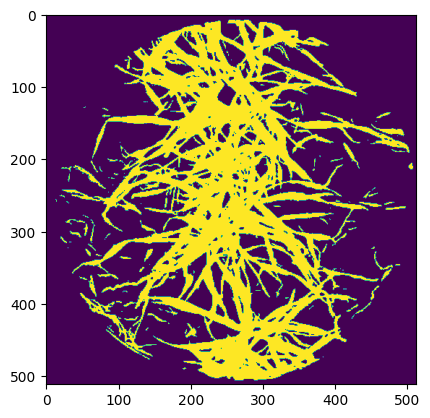

In [10]:
plt.imshow(output)
plt.show()

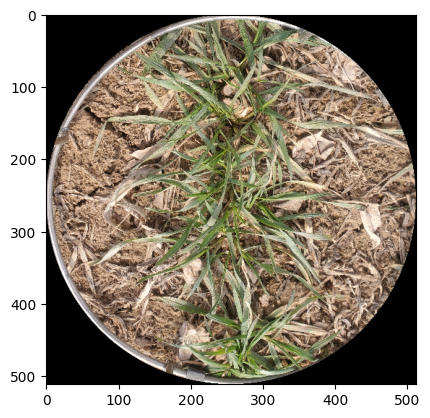

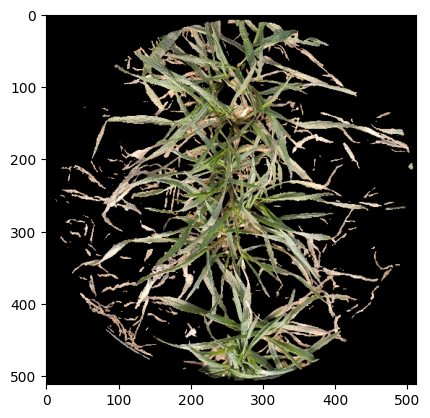

In [11]:
plt.imshow(image[:,:,::-1])
plt.show()

plt.imshow(new[:,:,::-1])
plt.show()

In [196]:
r,g,y

(0.42201675672995886, 17025, 23317)

In [12]:
input_shape=(512,512)


content='区号,绿叶比重,黄叶比重,绿叶面积,黄叶面积,总叶面积,色相,饱和度,色相2,饱和度2\n'

if not os.path.exists('phone_phenotypes_P_0409.csv'):
    with open('phone_phenotypes_P_0409.csv','w',encoding='utf-8') as f:
        f.write(content)
    load=[]   
else:
    csv=pd.read_csv('phone_phenotypes_P_0409.csv')
    load=csv['区号'].tolist()
files.sort()
with tqdm(total=len(files),desc='Progress:',postfix=dict,mininterval=0.3) as pbar:
    for index,file in enumerate(files):
        #label = cv2.imread(file,0)
        
        imgname=file.split('/')[-1].split('.')[0]
        if imgname in load:
            continue
       
        
        image = cv2.imread(file)
        h,w=image.shape[:2]

        #plt.imshow(image[:,:,::-1])
        #plt.show()


        if h<w:
            image=cv2.rotate(image,cv2.ROTATE_90_CLOCKWISE)
            #label=cv2.rotate(label,cv2.ROTATE_90_CLOCKWISE)
            h,w=w,h
        ratio=512/w
        temp=image.copy()

        temp=cv2.resize(temp,(int(w*ratio),int(h*ratio)))
        gray = cv2.cvtColor(temp, cv2.COLOR_RGB2GRAY)


        '''hsv_image = cv2.cvtColor(temp, cv2.COLOR_BGR2HSV)
        lower_gray = np.array([0, 0, 120], dtype=np.uint8)
        upper_gray = np.array([240, 250, 250], dtype=np.uint8)
        mask = cv2.inRange(hsv_image, lower_gray, upper_gray)
        temp = cv2.bitwise_and(temp, temp, mask=mask)
        plt.imshow(mask)
        plt.show()'''


        b,g,r=cv2.split(temp)
        crt1=abs(gray.astype(np.int32)-r.astype(np.int32))<50
        crt2=abs(gray.astype(np.int32)-g.astype(np.int32))<50
        crt3=abs(gray.astype(np.int32)-b.astype(np.int32))<50


        rcrt1=r.astype(np.int32)-b.astype(np.int32)>15
        rcrt2=g.astype(np.int32)-b.astype(np.int32)>15

        rcrt3=abs(r.astype(np.int32)-g.astype(np.int32))>20

        rcrt4=cv2.bitwise_and(rcrt1.astype(np.uint8),rcrt2.astype(np.uint8))
        rcrt=cv2.bitwise_and(rcrt3.astype(np.uint8),rcrt4.astype(np.uint8))




        crt4=gray>100
        crt5=cv2.bitwise_and(crt1.astype(np.uint8),crt2.astype(np.uint8))
        crt6=cv2.bitwise_and(crt3.astype(np.uint8),crt5.astype(np.uint8))

        crt7=cv2.bitwise_and(crt6.astype(np.uint8),1-rcrt2.astype(np.uint8))


        mask=cv2.bitwise_and(crt4.astype(np.uint8),crt7.astype(np.uint8))

        #plt.imshow(mask)
        #plt.show()

        temp = cv2.bitwise_and(temp, temp, mask=mask)




        gray = cv2.cvtColor(temp, cv2.COLOR_RGB2GRAY)
        kernel_size = (5, 5)  # 设置滤波核的大小
        gray = cv2.blur(gray, kernel_size)


        #plt.imshow(gray)
        #plt.show()

        circles = cv2.HoughCircles(gray, cv2.HOUGH_GRADIENT, 2, 500, param1=40, param2=80, minRadius=200, maxRadius=240)
        #print(circles)



        x1,x2,y1,y2=(round((circles[0][0][0]-circles[0][0][2])/ratio),
                 round((circles[0][0][0]+circles[0][0][2])/ratio),
                 round((circles[0][0][1]-circles[0][0][2])/ratio),
                 round((circles[0][0][1]+circles[0][0][2])/ratio))


        if y1<0:
            y1=0
        if y2>h:
            y2=h
        if x1<0:
            x1=0
        if x2>w:
            x2=w

        new=np.zeros((int(h),int(w),3),dtype=np.uint8)
        cv2.circle(new, (round(circles[0][0][0]/ratio), round(circles[0][0][1]/ratio)), round(circles[0][0][2]/ratio), (255, 255, 255), -1)
        
        image=cv2.bitwise_and(image,new)
        image=image[y1:y2,x1:x2,:]
        
        #plt.imshow(image)
        #plt.imshow(new)

        #label=cv2.bitwise_and(label,new[:,:,0])
        #label=label[y1:y2,x1:x2]

        #------------------------------------------#
        #   resize
        #------------------------------------------#        
        image=cv2.resize(image,(input_shape[0],input_shape[0]))
        #label=cv2.resize(label,(input_shape[0],input_shape[0]))

        img=torch.from_numpy(image/255).float().cuda()
        img=img.unsqueeze(0)
        img=img.permute(0,3,1,2)
        #lb=torch.Tensor([label]).cuda()

        with torch.no_grad():
            output=model(img)
        output = output[0].permute(1,2,0).cpu().argmax(axis=-1).numpy().astype(np.uint8)
        new = cv2.bitwise_and(image,image,mask=output)

        # r,g,y=get_green_yello_ratio(new,output)  
        r,g,y,h,s,h_y,s_y=get_green_yello_ratio(new,output)  
        

        with open('phone_phenotypes_P_0409.csv','a',encoding='utf-8') as f:
            f.write('{},{},{},{},{},{},{},{},{},{}\n'.format(imgname,r,1-r,g,y,g+y,h,s,h_y,s_y))
        '''except:
            print(file)
            with open('errors.txt','a',encoding='utf-8') as f:
                f.write('{}\n'.format(file))
                '''
        pbar.update(1)
        


Progress:: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 143/143 [01:10<00:00,  2.02it/s<class 'dict'>]


In [28]:
files

['/public/lab_share/nfs_data/raw_data/wheat/2022/AA221/winterhardness/2022C001_20230218_102522.jpg',
 '/public/lab_share/nfs_data/raw_data/wheat/2022/AA221/winterhardness/2022C002_20230218_102528.jpg',
 '/public/lab_share/nfs_data/raw_data/wheat/2022/AA221/winterhardness/2022C003_20230218_102535.jpg',
 '/public/lab_share/nfs_data/raw_data/wheat/2022/AA221/winterhardness/2022C004_20230218_102544.jpg',
 '/public/lab_share/nfs_data/raw_data/wheat/2022/AA221/winterhardness/2022C005_20230218_102551.jpg',
 '/public/lab_share/nfs_data/raw_data/wheat/2022/AA221/winterhardness/2022C006_20230218_102556.jpg',
 '/public/lab_share/nfs_data/raw_data/wheat/2022/AA221/winterhardness/2022C007_20230218_102603.jpg',
 '/public/lab_share/nfs_data/raw_data/wheat/2022/AA221/winterhardness/2022C008_20230218_102610.jpg',
 '/public/lab_share/nfs_data/raw_data/wheat/2022/AA221/winterhardness/2022C009_20230218_102618.jpg',
 '/public/lab_share/nfs_data/raw_data/wheat/2022/AA221/winterhardness/2022C010_20230218_102

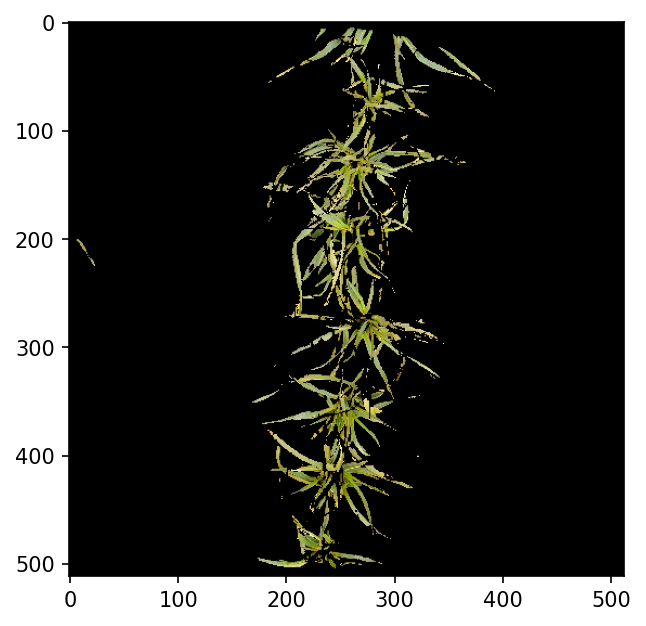

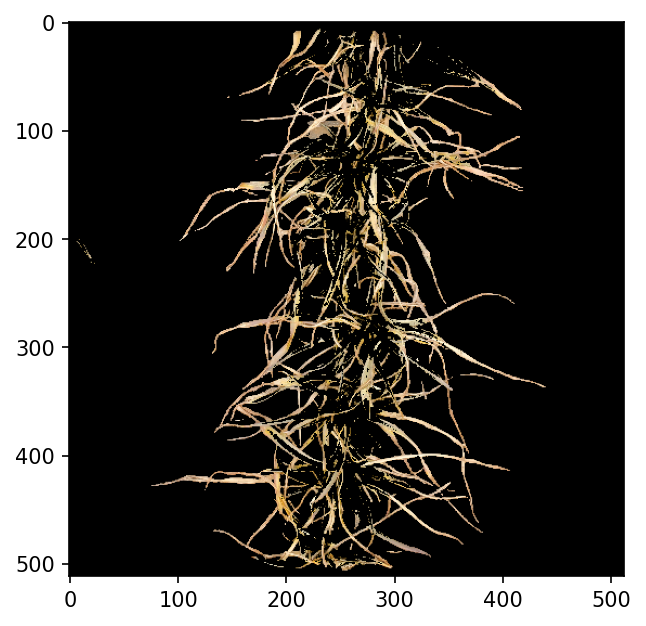

In [151]:
def get_plant_mask(image):
    B,G,R=cv2.split(image)
    B=B.astype(np.float32)
    G=G.astype(np.float32)
    R=R.astype(np.float32)
    r=R/(R+G+B+1e-10)
    b=B/(R+G+B+1e-10)
    g=G/(R+G+B+1e-10)
    ExG=2*g-b-r
    ExR=1.4*r-g
    ExV=ExG-ExR
    ExV_normalized = (ExV - np.min(ExV)) / (np.max(ExV) - np.min(ExV))
    ExV_scaled = (ExV_normalized * 255).astype(np.uint8)
    _, plant_mask = cv2.threshold(ExV_scaled, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    circle_mask = np.zeros_like(plant_mask)
    radius = plant_mask.shape[0] // 2
    cv2.circle(circle_mask, (radius, radius), radius, 255, -1)
    plant_mask = cv2.bitwise_and(plant_mask, circle_mask) 
    return plant_mask

mask=get_plant_mask(new)
green = cv2.bitwise_and(new,new,mask=mask)

plt.figure(dpi=150)
plt.imshow(green[:,:,::-1])
plt.show()

plt.figure(dpi=150)
plt.imshow((new-green)[:,:,::-1])
plt.show()

In [35]:
import pandas as pd
import numpy as np
import json

with open('region.json') as f:
    data=json.load(f)
df.iloc()[1:,:]

区号      绿叶比重      黄叶比重   绿叶面积   黄叶面积   总叶面积  \
1    2022C002_20230218_102528  0.429634  0.570366  18775  24925  43700   
2    2022C003_20230218_102535  0.518386  0.481614  31084  28879  59963   
3    2022C004_20230218_102544  0.358986  0.641014  13052  23306  36358   
4    2022C005_20230218_102551  0.596839  0.403161  24776  16736  41512   
5    2022C006_20230218_102556  0.228829  0.771171  10776  36316  47092   
..                        ...       ...       ...    ...    ...    ...   
425  2022C438_20230218_112337  0.057543  0.942457   1282  20997  22279   
426  2022C439_20230218_112342  0.373897  0.626103  13307  22283  35590   
427  2022C440_20230218_112347  0.265908  0.734092  10439  28819  39258   
428  2022C441_20230218_112356  0.207650  0.792350   7226  27573  34799   
429  2022C442_20230218_112408  0.052616  0.947384   1455  26198  27653   

            色相         饱和度  
1    18.958275  104.195025  
2    19.023686  104.518630  
3    19.089509  108.970179  
4    19.339331   80.646328  
5    18.437411  124.985874  
..         ...         ...  
425  17.621136   94.166786  
426  18.608403   67.241943  
427  18.419411  113.320969  
428  18.292170  101.679251  
429  17.125697   77.678372  

[429 rows x 8 columns]

In [101]:
df=pd.read_csv('phone_phenotypes_0316_1.csv',header=None)
df=df.iloc()[1:,:]
df[0]=df[0].apply(lambda x:x[4:8])
total_leaf=[]
df

0            1            2      3      4      5            6  \
1    C001  0.324000682  0.675999318  15206  31726  46932   22.4133214   
2    C002  0.429633867  0.570366133  18775  24925  43700  24.45009153   
3    C003  0.518386338  0.481613662  31084  28879  59963  25.99959975   
4    C004  0.358985643  0.641014357  13052  23306  36358  23.49957367   
5    C005  0.596839468  0.403160532  24776  16736  41512  28.61220065   
..    ...          ...          ...    ...    ...    ...          ...   
426  C438  0.057542978  0.942457022   1282  20997  22279  18.24157278   
427  C439  0.373897162  0.626102838  13307  22283  35590  24.68970072   
428  C440  0.265907586  0.734092414  10439  28819  39258  22.21274645   
429  C441  0.207649645  0.792350355   7226  27573  34799  20.83482284   
430  C442  0.052616353  0.947383647   1455  26198  27653  17.77329765   

               7            8            9  
1    108.6306997  18.21379941  101.1365126  
2    116.5663387  18.95827482  104.1950251  
3    111.2166539  19.02368585  104.5186301  
4    113.7501788  19.08950869  108.9701794  
5    97.48770146  19.33933054  80.64632762  
..           ...          ...          ...  
426  95.99690291  17.62113635  94.16678573  
427  74.47435717  18.60840291  67.24194272  
428  126.4930969  18.41941081  113.3209688  
429  104.0935372  18.29216988  101.6792514  
430  78.60496149  17.12569662  77.67837239  

[430 rows x 10 columns]

In [102]:
df=pd.read_csv('phone_phenotypes_0316_1.csv',header=None)
df=df.iloc()[1:,:]
df[0]=df[0].apply(lambda x:x[4:8])
total_leaf=[]

dic={'id':[],'region':[],'yellow_ratio':[],'total_leaf':[],'h1':[],'s1':[],'h2':[],'s2':[]} #,'total_leaf':[]}
for i in data.items():
    dic['region'].append(i[0])
    dic['id'].append(i[0])
    ls1,ls2,ls3,ls4,ls5,ls6=[],[],[],[],[],[]
    for j in i[1]:
        if j in df[0].tolist():
            ls1.append(  eval(df[df[0]==j][2].tolist()[0])  )
            ls2.append(  eval(df[df[0]==j][5].tolist()[0])  )
            ls3.append(  eval(df[df[0]==j][6].tolist()[0])  )
            ls4.append(  eval(df[df[0]==j][7].tolist()[0])  )
            ls5.append(  eval(df[df[0]==j][8].tolist()[0])  )
            ls6.append(  eval(df[df[0]==j][9].tolist()[0])  )
            
    dic['yellow_ratio'].append(sum(ls1)/len(ls1))
    dic['total_leaf'].append(sum(ls2)/len(ls2))
    dic['h1'].append(sum(ls3)/len(ls3))
    dic['s1'].append(sum(ls4)/len(ls4))
    dic['h2'].append(sum(ls5)/len(ls5))
    dic['s2'].append(sum(ls6)/len(ls6))
    
    #dic['total_leaf'].append(sum(ls3)/len(ls3))
    #total_leaf.append(sum(ls3)/len(ls3))
dic=pd.DataFrame(dic)
dic = dic.sort_values(by='id')

dic

id region  yellow_ratio  total_leaf         h1          s1         h2  \
89   1496A  1496A      0.857773     30918.5  19.750479  101.876048  18.221673   
131  1500B  1500B      0.777821     26825.5  21.311291   82.289535  18.844137   
110  1510B  1510B      0.990017     34150.0  17.122765   90.560597  17.012761   
94   1512B  1512B      0.813633     27689.0  20.999150  119.406339  18.999090   
171  1520B  1520B      0.932639     29459.0  18.374763  100.852499  17.617833   
..     ...    ...           ...         ...        ...         ...        ...   
93   S0146  S0146      0.931983     34732.5  18.262599  104.741289  17.543156   
153  S0147  S0147      0.507415     32489.0  26.356115   96.411978  19.277867   
95   S0148  S0148      0.900245     41855.5  18.658941  106.512129  17.454110   
102  S0149  S0149      0.733809     34897.0  21.913988   98.503079  18.353610   
214  S0150  S0150      0.463264     47041.0  26.896735  108.171071  18.952944   

             s2  
89    98.891263  
131   77.208864  
110   90.389464  
94   111.907787  
171   98.218592  
..          ...  
93   101.615207  
153   83.681553  
95   103.839364  
102   92.008382  
214   96.711565  

[221 rows x 8 columns]

In [54]:
dic.iloc()[:,1:].to_csv('phone_traits_rmvp.txt',sep='\t',index=None)


In [103]:
dic.to_csv('phone_traits_final.txt',sep='\t',index=None,header=None)


In [180]:
df=pd.read_csv('phone_phenotypes.csv',header=None)
df[6]=df[0].apply(lambda x:x[4:8])
total_leaf=[]
dic={'id':[],'region':[],'ratio':[]}#,'total_leaf':[]}
for i in data.items():
    dic['region'].append(i[0])
    dic['id'].append(i[0])
    ls1,ls2,ls3=[],[],[]
    for j in i[1]:
        if j in df[6].tolist():
            # ls1.append( df[df[6]==j][3].tolist()[0]/df[df[6]==j][4].tolist()[0]  )
            ls1.append( df[df[6]==j][2].tolist()[0]  )
            # ls2.append( df[df[6]==j][3].tolist()[0]  )
            # ls2.append( df[df[6]==j][3].tolist()[0]  )
            # ls3.append( df[df[6]==j][5].tolist()[0]  )
            # ls3.append( df[df[6]==j][5].tolist()[0]  )
    dic['ratio'].append(sum(ls1)/len(ls1))
    #dic['green_leaf'].append(sum(ls2)/len(ls2))
    #dic['total_leaf'].append(sum(ls3)/len(ls3))
    #total_leaf.append(sum(ls3)/len(ls3))
dic=pd.DataFrame(dic)
dic = dic.sort_values(by='id')
dic.to_csv('phone_traits_freeze.txt',sep='\t',index=None,header=None)

dic


id region     ratio
89   1496A  1496A  0.857787
131  1500B  1500B  0.777830
110  1510B  1510B  0.990018
94   1512B  1512B  0.813636
171  1520B  1520B  0.932639
..     ...    ...       ...
93   S0146  S0146  0.931988
153  S0147  S0147  0.507433
95   S0148  S0148  0.900245
102  S0149  S0149  0.733777
214  S0150  S0150  0.463231

[221 rows x 3 columns]

In [164]:
dic['ratio'].tolist()

[0.16860645934299812,
 0.2962152950998033,
 0.010552015630362607,
 0.21821523102625118,
 0.07511403853069548,
 0.07294630796665062,
 0.5610053101275823,
 0.23323331979020193,
 1.2053049839482133,
 0.9379428740129019,
 0.5091034608558582,
 0.28377762723973776,
 0.0990833414857479,
 0.23513152477200885,
 1.2687098966086643,
 1.2734398312117965,
 0.49782231621013157,
 0.7397236256358235,
 0.14152254094055722,
 0.5357374544748291,
 0.081397177601364,
 0.7089226757339151,
 0.38553903432011805,
 0.12949732639141665,
 0.6788959903356828,
 0.1174368932038835,
 0.1175930219739475,
 0.1251241852762748,
 0.5337938911607812,
 0.6583953854778347,
 0.4709330557508946,
 0.8998338550632814,
 0.5190915075707703,
 0.01287036071945556,
 0.11939828304777911,
 0.3096577851476753,
 0.19666760028252028,
 0.6843809165804273,
 0.2942267343083774,
 0.7726988078100723,
 0.5516434651370877,
 0.5039095324773326,
 0.07159279480210919,
 0.410529321682527,
 0.30652379579086614,
 0.6222454668425301,
 0.059658666683562

In [166]:
d=pd.read_csv('/public/lab_share/nfs_data/AA491/AA221.pruned.pe60.r05.3.gcta.Q',sep='\t',header=None)
#d['total_leaf']=dic['total_leaf'].tolist()
d.to_csv('cor.txt',sep='\t',index=None,header=None)

d

0      1         2         3
0    1496A  1496A  0.346719  0.426272
1    1500B  1500B  0.072407  0.030851
2    1510B  1510B  0.302740  0.128904
3    1512B  1512B  0.064582  0.532997
4    1520B  1520B  0.077046  0.392268
..     ...    ...       ...       ...
216  S0146  S0146  0.088808  0.683901
217  S0147  S0147  0.999980  0.000010
218  S0148  S0148  0.058028  0.453320
219  S0149  S0149  0.281382  0.003154
220  S0150  S0150  0.999980  0.000010

[221 rows x 4 columns]

In [31]:
pwd

'/public/home/fjsun/workspace/UNet'

In [49]:
dic.to_csv('phone_traits.txt',sep='\t',index=None,header=None)


In [ ]:
df=pd.read_csv('phone_phenotypes.csv',sep='\t',header=None)


In [21]:
dic.to_csv('phone_traits.txt',sep='\t',index=None,header=None)

In [22]:
i

('1677B', ['C059', 'C366'])

In [7]:
file

'/public/lab_share/nfs_data/raw_data/cellphone/zhaoxian2022/20230218SamsungS10/周麦13_葫芦头RIL/2022Z127_20230218_092205.jpg'

In [10]:
img=torch.from_numpy(image/255).cuda()
img=img.unsqueeze(0)
img=img.permute(0,3,1,2)

img.shape

torch.Size([1, 3, 1024, 1024])

In [11]:
label.shape,new.shape

((1280, 960), (4032, 3024, 3))

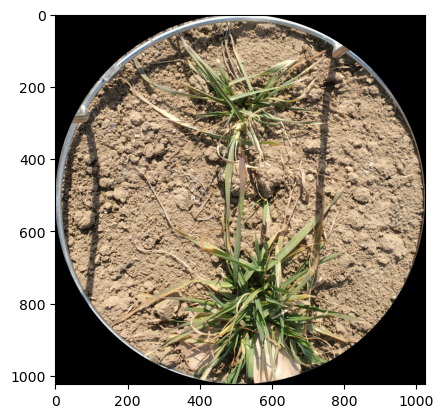

In [15]:
plt.imshow(image[:,:,::-1])
plt.show()

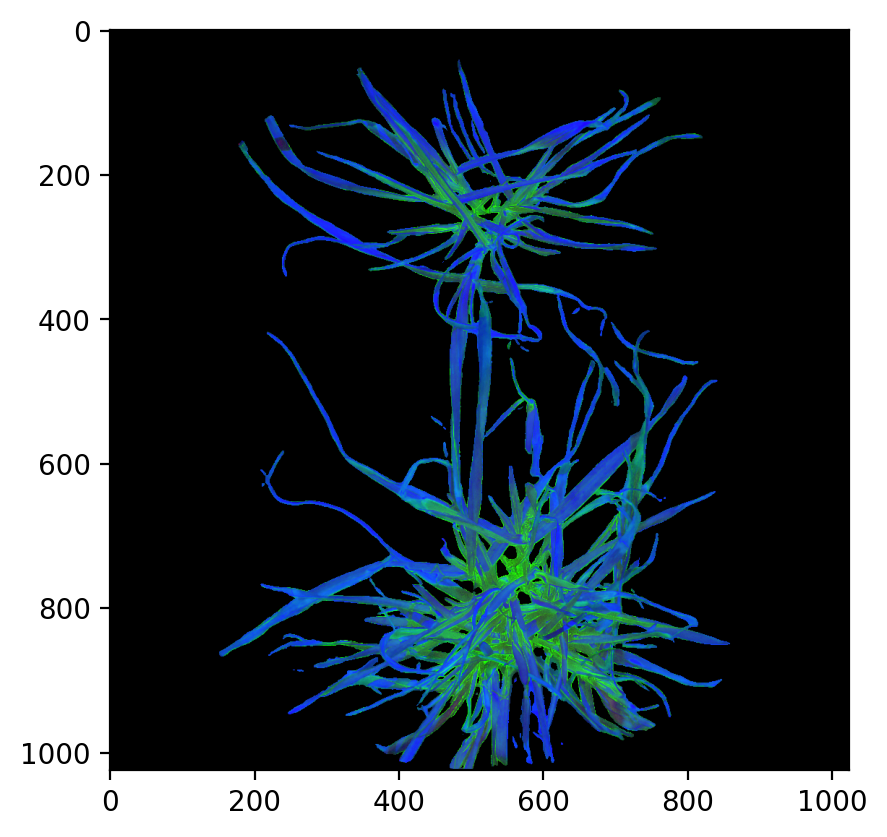

In [25]:
plt.figure(dpi=200)
plt.imshow(hsv)
plt.show()

0.5129015104849451

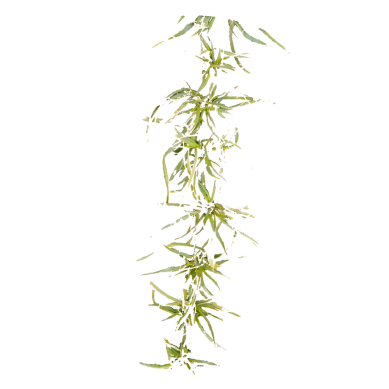

In [146]:
hsv=cv2.cvtColor(new,cv2.COLOR_BGR2HSV)


lower_green = np.array([25, 40, 0])
upper_green = np.array([255, 255, 240])

green_mask = cv2.inRange(hsv, lower_green, upper_green)

res=cv2.bitwise_or(image,255-cv2.merge([green_mask,green_mask,green_mask]))

plt.imshow(res[:,:,::-1])
plt.axis('off')
plt.show()

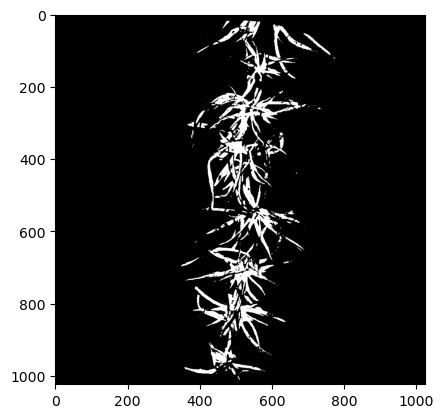

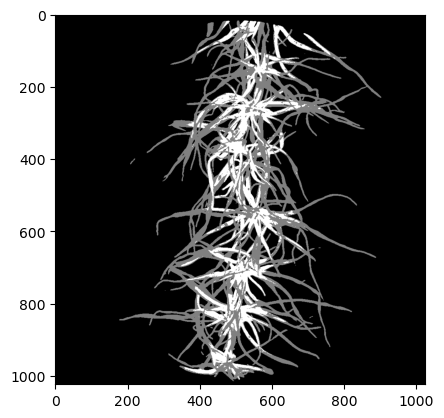

In [129]:
plt.imshow(green_mask,cmap='gray')
plt.show()
plt.imshow(yellow_mask,cmap='gray')
plt.show()

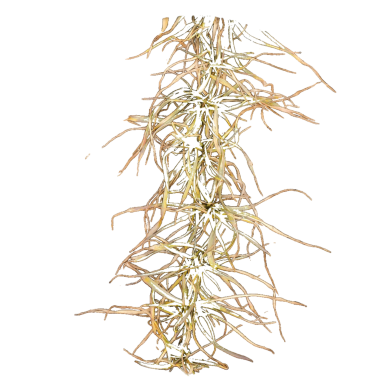

In [145]:
yellow_mask=output*255-green_mask
#res=new-res

res=cv2.bitwise_or(image,255-cv2.merge([yellow_mask,yellow_mask,yellow_mask]))


plt.imshow(res[:,:,::-1])
plt.axis('off')
plt.show()




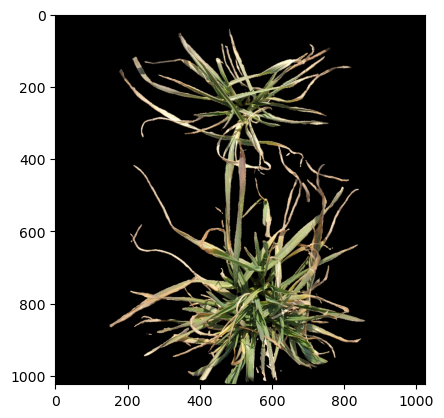

In [12]:
plt.imshow(new[:,:,::-1])
plt.show()

In [48]:
import pandas as pd
df=pd.read_csv('result.csv')


name     ratio
0      2022C001_20230218_102522  0.289206
1      2022C002_20230218_102528  0.397678
2      2022C003_20230218_102535  0.486397
3      2022C004_20230218_102544  0.338746
4      2022C005_20230218_102551  0.577187
..                          ...       ...
969  2023LNE752_20230221_135731  0.000239
970  2023LNE756_20230221_135740  0.000131
971  2023LNE758_20230221_135744  0.000520
972  2023LNE760_20230221_135748  0.000204
973  2023LNE762_20230221_135753  0.499871

[974 rows x 2 columns]

In [87]:
d={'区号':[],'绿叶占比':df['ratio'],'黄叶占比':1-df['ratio'],'等级':[]}

for i,j in zip(df['name'],df['ratio']):
    
    d['区号'].append(i.split('_')[0])
    d['等级'].append(5-int(j*5))
    
d=pd.DataFrame(d)
    

In [52]:
max(df['ratio'])

0.6354615496566658

In [85]:
df[df['ratio']==max(df['ratio'])]

name     ratio
751  2023LNE312_20230221_132909  0.635462

In [78]:
j=0.2
5-int(j*5)

4

In [88]:
d.to_csv('output.csv',index=False)

In [60]:
for index,file in enumerate(files_s):
    #label = cv2.imread(file,0)
    imgname=file.split('/')[-1].split('.')[0]
    if imgname!='2023LNE312_20230221_132909':
        continue
    break
print(imgname)

2023LNE312_20230221_132909


In [9]:
def get_green_yello_ratio_test(new,mask):
    hsv=cv2.cvtColor(new,cv2.COLOR_BGR2HSV)
    lower_green = np.array([25, 45, 0])
    upper_green = np.array([255, 255, 240])
    green_mask = cv2.inRange(hsv, lower_green, upper_green)
    
    img1=cv2.bitwise_and(new,cv2.merge([green_mask,green_mask,green_mask]))
    img2=new-img1
    return img1,img2
    
    #green_pixels = cv2.countNonZero(green_mask)
    #total_pixels = cv2.countNonZero(mask)
    #ratio_green = green_pixels / total_pixels
    
    
    
    #return ratio_green

get_green_yello_ratio(new,output)  

0.4926318979808324

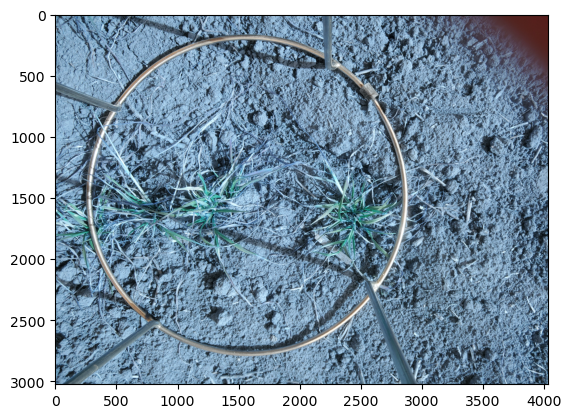

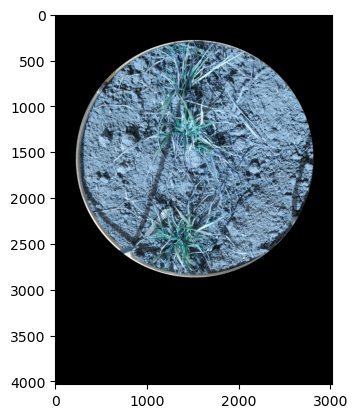

In [25]:
random.shuffle(files)
for index,file in enumerate(files[15:16]):
    imgname=file.split('/')[-1].split('.')[0]
    #label = cv2.imread(file,0)
    image = cv2.imread(file)
    plt.imshow(image)
    plt.show()
    h,w=image.shape[:2]
    if h<w:
        image=cv2.rotate(image,cv2.ROTATE_90_CLOCKWISE)
        #label=cv2.rotate(label,cv2.ROTATE_90_CLOCKWISE)
        h,w=w,h
    ratio=512/w
    temp=image.copy()
    temp=cv2.resize(temp,(int(w*ratio),int(h*ratio)))
    gray = cv2.cvtColor(temp, cv2.COLOR_RGB2GRAY)
    
    b,g,r=cv2.split(temp)
    crt1=abs(gray.astype(np.int32)-r.astype(np.int32))<50
    crt2=abs(gray.astype(np.int32)-g.astype(np.int32))<50
    crt3=abs(gray.astype(np.int32)-b.astype(np.int32))<50


    rcrt1=r.astype(np.int32)-b.astype(np.int32)>15
    rcrt2=g.astype(np.int32)-b.astype(np.int32)>15

    rcrt3=abs(r.astype(np.int32)-g.astype(np.int32))>20

    rcrt4=cv2.bitwise_and(rcrt1.astype(np.uint8),rcrt2.astype(np.uint8))
    rcrt=cv2.bitwise_and(rcrt3.astype(np.uint8),rcrt4.astype(np.uint8))




    crt4=gray>100
    crt5=cv2.bitwise_and(crt1.astype(np.uint8),crt2.astype(np.uint8))
    crt6=cv2.bitwise_and(crt3.astype(np.uint8),crt5.astype(np.uint8))

    crt7=cv2.bitwise_and(crt6.astype(np.uint8),1-rcrt2.astype(np.uint8))


    mask=cv2.bitwise_and(crt4.astype(np.uint8),crt7.astype(np.uint8))

    #plt.imshow(mask)
    #plt.show()

    temp = cv2.bitwise_and(temp, temp, mask=mask)




    gray = cv2.cvtColor(temp, cv2.COLOR_RGB2GRAY)
    kernel_size = (5, 5)  # 设置滤波核的大小
    gray = cv2.blur(gray, kernel_size)


    #plt.imshow(gray)
    #plt.show()

    circles = cv2.HoughCircles(gray, cv2.HOUGH_GRADIENT, 2, 500, param1=40, param2=80, minRadius=200, maxRadius=240)
    x1,x2,y1,y2=(round((circles[0][0][0]-circles[0][0][2])/ratio),
             round((circles[0][0][0]+circles[0][0][2])/ratio),
             round((circles[0][0][1]-circles[0][0][2])/ratio),
             round((circles[0][0][1]+circles[0][0][2])/ratio))

    new=np.zeros((int(h),int(w),3),dtype=np.uint8)
    cv2.circle(new, (round(circles[0][0][0]/ratio), round(circles[0][0][1]/ratio)), round(circles[0][0][2]/ratio), (255, 255, 255), -1)

    image=cv2.bitwise_and(image,new)
    plt.imshow(image)
    plt.show()
    image=image[y1:y2,x1:x2,:]
    #label=cv2.bitwise_and(label,new[:,:,0])
    #label=label[y1:y2,x1:x2]

    #------------------------------------------#
    #   resize
    #------------------------------------------#        
    image=cv2.resize(image,(input_shape[0],input_shape[0]))
    #label=cv2.resize(label,(input_shape[0],input_shape[0]))

    img=torch.Tensor([image/255]).cuda()
    img=img.permute(0,3,1,2)
    #lb=torch.Tensor([label]).cuda()
    with torch.no_grad():
        output=model(img)
    output = output[0].permute(1,2,0).cpu().argmax(axis=-1).numpy().astype(np.uint8)


    new = cv2.bitwise_and(image,image,mask=output)
    img1,img2=get_green_yello_ratio_test(new,output)
    if not os.path.exists('green_yellow2/'+imgname):
        os.mkdir('green_yellow2/'+imgname)
    cv2.imwrite('green_yellow2/{}/segmentation.jpg'.format(imgname),new)
    cv2.imwrite('green_yellow2/{}/segmentation-green.jpg'.format(imgname),img1)
    cv2.imwrite('green_yellow2/{}/segmentation-yellow.jpg'.format(imgname),img2)
    


In [101]:
imgname

'2022C001_20230218_102522'

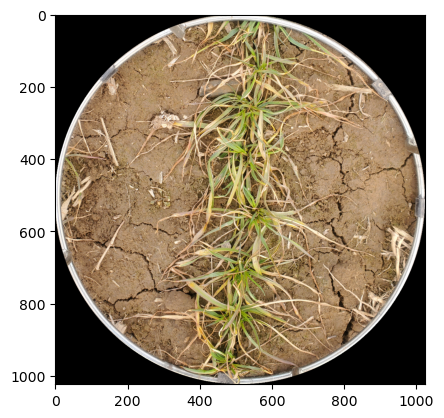

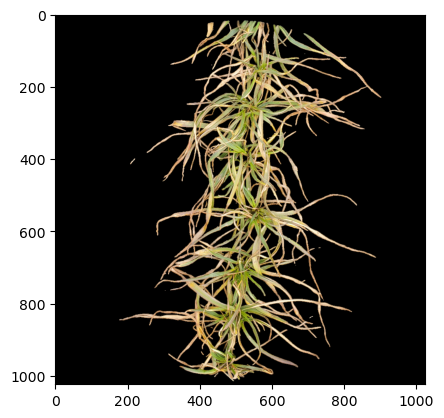

In [98]:
plt.imshow(image[:,:,::-1])
plt.show()

plt.imshow(new[:,:,::-1])
plt.show()